In [ ]:
import os
from typing import List

import imageio.v3 as iio
import pandas as pd
from datasets import Dataset, DatasetDict, Features, Image, Value
from tqdm.notebook import tqdm

from monocake.common.notebook import nb_utils_lib as nb
from monocake.research.kuafu.infra.learning.dataset import hg_dataset_lib


In [ ]:
PROMPT = "An indoor panoramic environment map image."

input_root: List[str] = [
    "" # Add your panoramic image dir, can be multiple.
]
output_root = ""

os.makedirs(f"{output_root}/CleARDataset", parents=True, exist_ok=True)
os.makedirs(f"{output_root}/CleAR_HG", parents=True, exist_ok=True)

## Inspect

In [3]:
dataset = hg_dataset_lib.EnvMapDataset(
    data_root=input_root,
    img_size=(512, 256),
    use_fixed_splits=True,
    use_estimated_semantic_images=True,
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
len(dataset)

32736

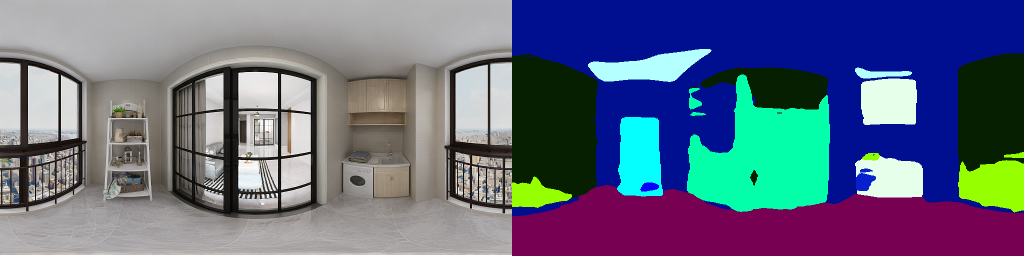

In [5]:
img, semantics = dataset[0]
nb.print_img(img, semantics)


## Generate

In [ ]:
dataset = hg_dataset_lib.EnvMapDataset(
    data_root=input_root,
    img_size=(512, 256),
    use_fixed_splits=True,
    use_estimated_semantic_images=True,
)

dataset_train, dataset_test = dataset.get_train_test_split()

for dataset_name, dataset in tqdm(
    zip(["train", "test"], [dataset_train, dataset_test])
):
    i_item = 0
    df = pd.DataFrame(columns=["prompt", "rgb", "semantic", "envmap"])

    for data_item in tqdm(dataset, leave=False):
        img, semantics = data_item

        # Ground truth RGB.
        iio.imwrite(
            f"{output_root}/CleARDataset/{dataset_name}/{i_item:08}_rgb.png",
            img,
        )

        # Conditioning Semantics.
        iio.imwrite(
            f"{output_root}/CleARDataset/{dataset_name}/{i_item:08}_semantics.png",
            semantics,
        )

        df.loc[len(df)] = [PROMPT, f"{i_item:08}_rgb.png", f"{i_item:08}_semantics.png", f"{i_item:08}_rgb.png"]
        i_item += 1

    with open(
        f"{output_root}/CleARDataset/{dataset_name}/metadata.jsonl", "w"
    ) as f:
        f.write(df.to_json(orient="records", lines=True))

0it [00:00, ?it/s]

  0%|          | 0/30053 [00:00<?, ?it/s]

Error at index 3717: broken PNG file (chunk b'\x00\x00\x00\x00')
Error at index 12735: image file is truncated


  0%|          | 0/2683 [00:00<?, ?it/s]

In [ ]:
dsd = {}

for dataset_name in ["train", "test"]:
    df = pd.read_json(
        f"{output_root}/CleARDataset/{dataset_name}/metadata.jsonl", lines=True
    )

    rows = []

    for i in range(len(df)):
        data = df.loc[i]

        n_id = int(data["rgb"].split("_")[0]) - 1

        rows.append({
            "id": f"{n_id:08}",
            "prompt": data["prompt"],
            "rgb": f"{output_root}/CleARDataset/{dataset_name}/{n_id:08}_rgb.png",
            "semantic": f"{output_root}/CleARDataset/{dataset_name}/{n_id:08}_semantics.png",
            "envmap": f"{output_root}/CleARDataset/{dataset_name}/{n_id:08}_rgb.png",
        })

    features = Features({
        "id": Value("string"),
        "prompt": Value("string"),
        "rgb": Image(),
        "semantic": Image(),
        "envmap": Image(),
    })

    dsd[dataset_name] = Dataset.from_pandas(pd.DataFrame(rows), features=features, preserve_index=False)

dsd = DatasetDict(dsd)
dsd.save_to_disk(f"{output_root}/CleAR_HG")


Saving the dataset (0/23 shards):   0%|          | 0/30053 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/2683 [00:00<?, ? examples/s]